<a href="https://colab.research.google.com/github/Sebastian-Torres-Gamboa/SenalesSistemas/blob/main/SEBASTIAN_Otra_copia_de_Copia_de_Borrador_MLP_200_decadas_final_final_FINAL_comillas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Etapa 1

[Stage 1] Building synthetic dataset...
  built 2000/32000
  built 4000/32000
  built 6000/32000
  built 8000/32000
  built 10000/32000
  built 12000/32000
  built 14000/32000
  built 16000/32000
  built 18000/32000
  built 20000/32000
  built 22000/32000
  built 24000/32000
  built 26000/32000
  built 28000/32000
  built 30000/32000
  built 32000/32000
  built 2000/8000
  built 4000/8000
  built 6000/8000
  built 8000/8000
  built 2000/8000
  built 4000/8000
  built 6000/8000
  built 8000/8000
Done in 362.2s
Shapes:
  X_train: (32000, 1024)
  P_per_train: (32000, 513)
  P_welch_train: (32000, 513)
  freqs: (513,)
Saved dataset to: /content/mlp_psd_stage1_out/dataset_stage1.npz


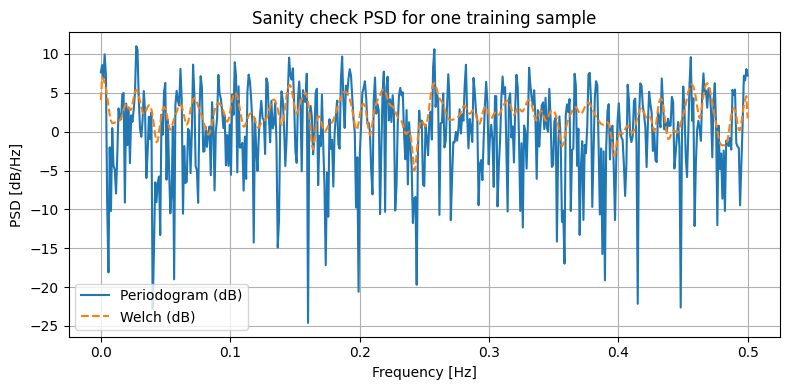

In [ ]:
# =============================================
# Stage 1 — Synthetic Dataset Builder (Colab-Ready)
# Goal: Generate time-domain signals (N=1024) and their one-sided PSD (Periodogram & Welch) in dB
# Output: dataset_stage1.npz with split arrays and freqs
# Notes:
#  - This cell is self-contained: install imports, generate, split, save, preview.
#  - Designed for Colab; all code is commented in English as requested.
#  - Data will be used later by Stage 2 (MLP training in PyTorch).
# =============================================

import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, welch

# ------------------------------
# 1) Parameters (edit as needed)
# ------------------------------
SEED = 7
np.random.seed(SEED)

N = 1024                # samples per signal
FS = 1           # sampling rate (Hz). Only sets freq axis scale.
ONE_SIDED_LEN = N // 2 + 1

# Dataset sizes (duplicated vs the earlier plan)
TRAIN_SAMPLES = 16000*2
VAL_SAMPLES   =  4000*2
TEST_SAMPLES  =  4000*2

# Welch params (per spec)
WELCH_NPERSEG = 256
WELCH_NOVER   = 128
WINDOW = "hann"

# Output folder and path
OUT_DIR = "/content/mlp_psd_stage1_out"
OUT_PATH = os.path.join(OUT_DIR, "dataset_stage1.npz")
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------
# 2) Signal Generators
# ------------------------------
rng = np.random.default_rng(SEED)

def gen_white(N):
    # White Gaussian noise
    x = rng.normal(0.0, 1.0, size=N)
    return x.astype(np.float32)

def gen_multisine(N, fs):
    # Sum of 1..5 sines with random freq/phase/amplitude + small noise
    t = np.arange(N) / fs
    k = rng.integers(1, 6)
    x = np.zeros(N, dtype=np.float64)
    for _ in range(k):
        f  = rng.uniform(0.01, 0.45) * fs
        A  = rng.uniform(0.3, 2.0)
        ph = rng.uniform(-np.pi, np.pi)
        x += A * np.sin(2*np.pi*f*t + ph)
    x += 0.1 * rng.normal(0.0, 1.0, size=N)
    x -= np.mean(x)
    return x.astype(np.float32)

def gen_ar2(N):
    # AR(2) stable process
    r = rng.uniform(0.2, 0.95)
    w = rng.uniform(0.0, np.pi)
    a1 = 2*r*np.cos(w)
    a2 = -r**2
    e = rng.normal(0.0, 1.0, size=N+200)
    y = np.zeros_like(e)
    for n in range(2, len(e)):
        y[n] = a1*y[n-1] + a2*y[n-2] + e[n]
    x = y[-N:]
    x -= np.mean(x)
    x /= (np.std(x) + 1e-8)
    return x.astype(np.float32)

def gen_accel_like(N, fs):
    # Low-freq sines + sparse impulses (jerk-like)
    t = np.arange(N) / fs
    x = np.zeros(N, dtype=np.float64)
    for _ in range(rng.integers(1, 4)):
        f  = rng.uniform(0.01, 0.15) * fs
        A  = rng.uniform(0.4, 1.6)
        ph = rng.uniform(-np.pi, np.pi)
        x += A * np.sin(2*np.pi*f*t + ph)
    # sparse impulses
    for _ in range(rng.integers(1, 6)):
        idx = rng.integers(0, N)
        amp = rng.uniform(2.0, 6.0)
        if idx < N:
            x[idx] += amp
    x += 0.2 * rng.normal(0.0, 1.0, size=N)
    x -= np.mean(x)
    return x.astype(np.float32)

def gen_ecg_like(N, fs):
    # Super-simplified ECG-like waveform: baseline drift + periodic sharp peaks
    t = np.arange(N) / fs
    base = 0.05 * np.sin(2*np.pi*0.02*t)
    x = base.copy()
    hr_hz = rng.uniform(0.8, 2.0)
    r_period = int(max(1, round(fs / (hr_hz + 1e-6))))
    # Add narrow Gaussian-like pulses (R peaks)
    width = max(1, int(0.01*N))
    for k in range(0, N, r_period):
        win = np.exp(-0.5*((np.arange(N)-k)/(width+1e-6))**2)
        x += rng.uniform(0.8, 2.0) * win
    x += 0.03 * rng.normal(0.0, 1.0, size=N)
    x -= np.mean(x)
    x /= (np.std(x) + 1e-8)
    return x.astype(np.float32)

GENS = [
    lambda: gen_white(N),
    lambda: gen_multisine(N, FS),
    lambda: gen_ar2(N),
    lambda: gen_accel_like(N, FS),
    lambda: gen_ecg_like(N, FS),
]

# ------------------------------
# 3) PSD Helpers (one-sided, in dB)
# ------------------------------

def psd_periodogram_db(x, fs, nfft):
    f, Pxx = periodogram(x, fs=fs, window=WINDOW, nfft=nfft, detrend=False,
                         return_onesided=True, scaling="density")
    Pxx_dB = 10.0 * np.log10(np.maximum(Pxx, 1e-16))
    return f, Pxx_dB.astype(np.float32)

def psd_welch_db(x, fs, nfft, nperseg, noverlap):
    f, Pxx = welch(x, fs=fs, window=WINDOW, nperseg=nperseg, noverlap=noverlap,
                   nfft=nfft, detrend=False, return_onesided=True, scaling="density")
    Pxx_dB = 10.0 * np.log10(np.maximum(Pxx, 1e-16))
    return f, Pxx_dB.astype(np.float32)

# ------------------------------
# 4) Batch builder
# ------------------------------

def build_split(count):
    X = np.zeros((count, N), dtype=np.float32)
    Pper = np.zeros((count, ONE_SIDED_LEN), dtype=np.float32)
    Pwel = np.zeros((count, ONE_SIDED_LEN), dtype=np.float32)

    freqs_ref = None
    for i in range(count):
        x = GENS[i % len(GENS)]()
        f1, pper = psd_periodogram_db(x, FS, N)
        f2, pwel = psd_welch_db(x, FS, N, WELCH_NPERSEG, WELCH_NOVER)
        if freqs_ref is None:
            freqs_ref = f1
        # Safety checks
        assert pper.shape[0] == ONE_SIDED_LEN
        assert pwel.shape[0] == ONE_SIDED_LEN
        X[i, :] = x
        Pper[i, :] = pper
        Pwel[i, :] = pwel
        if (i+1) % 2000 == 0:
            print(f"  built {i+1}/{count}")
    return X, Pper, Pwel, freqs_ref

# ------------------------------
# 5) Build full dataset (train/val/test)
# ------------------------------
start = time.time()
print("[Stage 1] Building synthetic dataset...")
X_train, P_per_train, P_welch_train, freqs = build_split(TRAIN_SAMPLES)
X_val,   P_per_val,   P_welch_val,   _     = build_split(VAL_SAMPLES)
X_test,  P_per_test,  P_welch_test,  _     = build_split(TEST_SAMPLES)

print(f"Done in {time.time()-start:.1f}s")
print("Shapes:")
print("  X_train:", X_train.shape)
print("  P_per_train:", P_per_train.shape)
print("  P_welch_train:", P_welch_train.shape)
print("  freqs:", freqs.shape)

# ------------------------------
# 6) Save .npz with split arrays
# ------------------------------
np.savez(OUT_PATH,
         X_train=X_train, X_val=X_val, X_test=X_test,
         P_per_train=P_per_train, P_per_val=P_per_val, P_per_test=P_per_test,
         P_welch_train=P_welch_train, P_welch_val=P_welch_val, P_welch_test=P_welch_test,
         freqs=freqs)
print(f"Saved dataset to: {OUT_PATH}")

# ------------------------------
# 7) Quick sanity plots (small sample)
# ------------------------------
idx = 0
x0 = X_train[idx]
f0 = freqs
_, pper0 = psd_periodogram_db(x0, FS, N)
_, pwel0 = psd_welch_db(x0, FS, N, WELCH_NPERSEG, WELCH_NOVER)

plt.figure(figsize=(8,4))
plt.plot(f0, pper0, label='Periodogram (dB)')
plt.plot(f0, pwel0, label='Welch (dB)', linestyle='--')
plt.title('Sanity check PSD for one training sample')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Etapa 2

Stage1 keys: ['X_train', 'X_val', 'X_test', 'P_per_train', 'P_per_val', 'P_per_test', 'P_welch_train', 'P_welch_val', 'P_welch_test', 'freqs']
Shapes:
  X_train: (32000, 1024) y_train: (32000, 1026)
  X_val  : (8000, 1024) y_val  : (8000, 1026)
  X_test : (8000, 1024) y_test : (8000, 1026)
Model parameters: 1.97 M
Epoch 001 | dt=5.0s | train_loss=0.4563 | val_loss=0.4225 | train_r=0.375 | val_r=0.376 [BEST]
Epoch 002 | dt=4.5s | train_loss=0.3993 | val_loss=0.3868 | train_r=0.389 | val_r=0.386 [BEST]
Epoch 003 | dt=4.0s | train_loss=0.3328 | val_loss=0.3355 | train_r=0.444 | val_r=0.441 [BEST]
Epoch 004 | dt=4.0s | train_loss=0.2691 | val_loss=0.3162 | train_r=0.460 | val_r=0.456 [BEST]
Epoch 005 | dt=4.5s | train_loss=0.2388 | val_loss=0.3035 | train_r=0.472 | val_r=0.465 [BEST]
Epoch 006 | dt=4.0s | train_loss=0.2268 | val_loss=0.2931 | train_r=0.477 | val_r=0.467 [BEST]
Epoch 007 | dt=4.1s | train_loss=0.2200 | val_loss=0.2938 | train_r=0.478 | val_r=0.469
Epoch 008 | dt=4.4s | trai

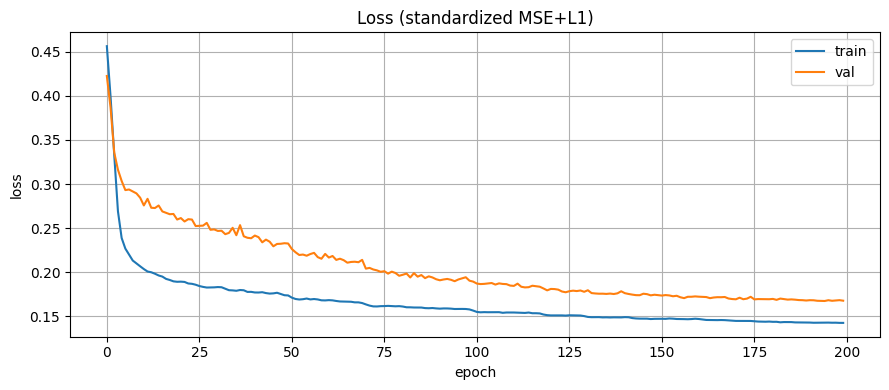

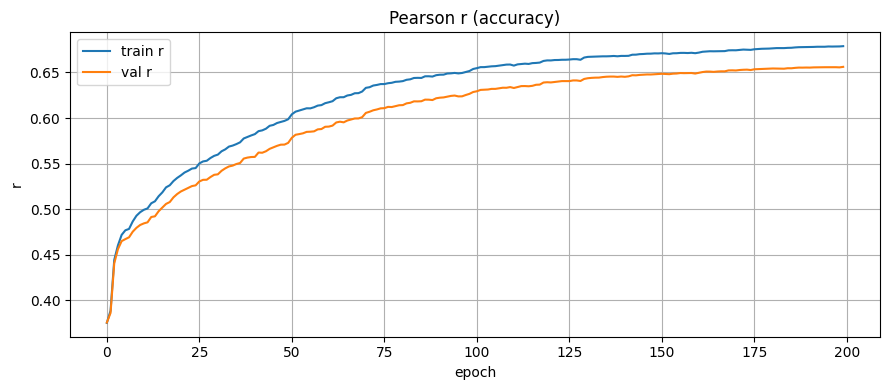

[loaded best] epoch=195 val_loss=0.1673
TEST metrics -> MAE=3.5702 RMSE=5.2314 R2=0.8664 r=0.6545


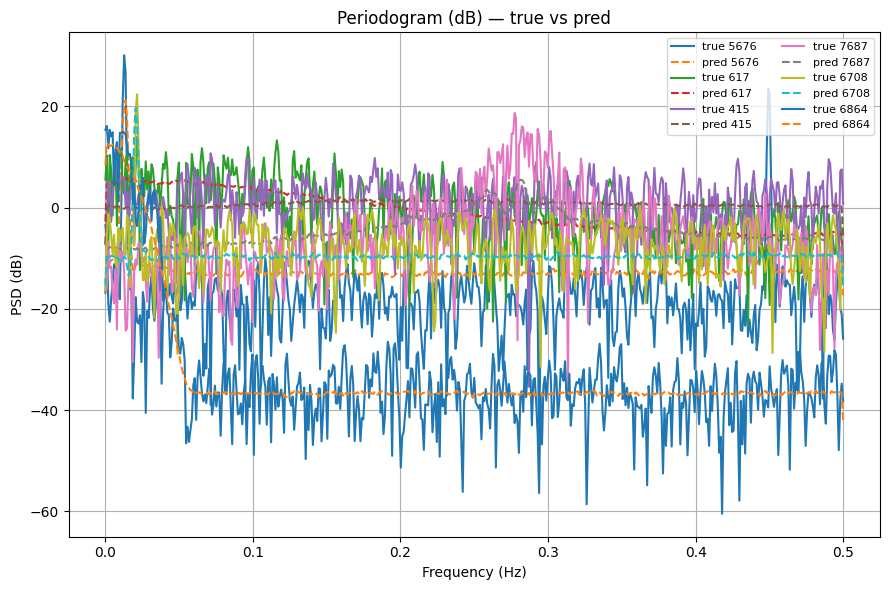

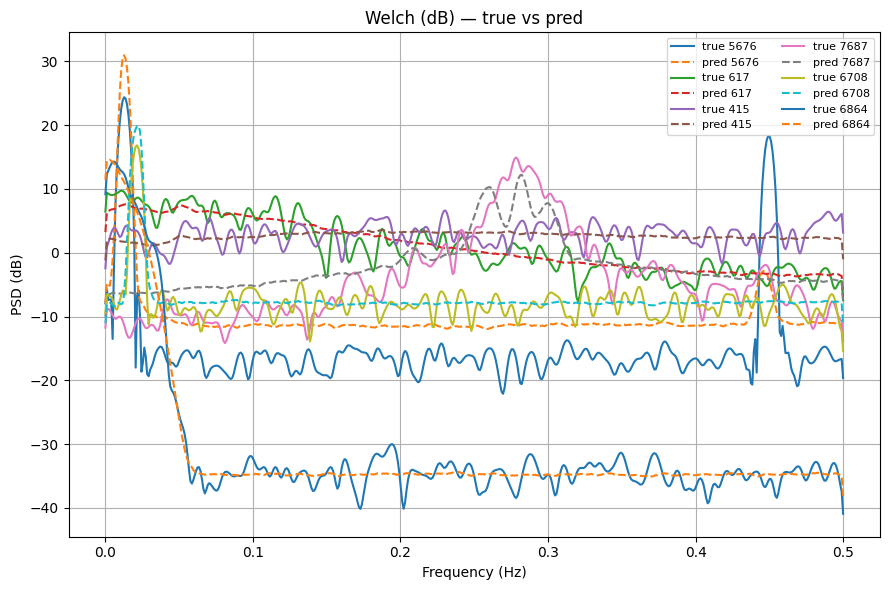

Outputs saved in: /content/mlp_psd_stage2_out
Saved TorchScript: /content/mlp_psd_stage2_out/mlp_psd_scripted.pt
Installing onnx and onnxruntime...
ONNX installed.
[warn] First ONNX export attempt failed: ModuleNotFoundError("No module named 'onnxscript'")
Saved ONNX with legacy exporter (fallback): /content/mlp_psd_stage2_out/mlp_psd.onnx
Stage 3 complete. Outputs saved in: /content/mlp_psd_stage2_out


In [ ]:
# =============================================================
# Stage 2 — MLP to predict One-Sided PSD (Periodogram & Welch)
# Colab-ready • PyTorch • Robust checkpoints • Clean metrics
# =============================================================
# This notebook assumes Stage 1 saved a split dataset at:
#   /content/mlp_psd_stage1_out/dataset_stage1.npz
# with keys: X_train/X_val/X_test, P_per_*, P_welch_*, freqs
#
# All code is commented in English. Run cells top-to-bottom.
# =============================================================

import os, time, json, math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------
# Reproducibility & device
# ----------------------
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ----------------------
# Paths & constants
# ----------------------
STAGE1_PATH = "/content/mlp_psd_stage1_out/dataset_stage1.npz"
OUT_DIR     = "/content/mlp_psd_stage2_out"
os.makedirs(OUT_DIR, exist_ok=True)

BEST_CKPT        = os.path.join(OUT_DIR, "best_mlp_psd.pt")
EPOCH_CKPT_DIR   = os.path.join(OUT_DIR, "checkpoints_per_epoch")
os.makedirs(EPOCH_CKPT_DIR, exist_ok=True)
CURVES_LOSS_PNG  = os.path.join(OUT_DIR, "curves_loss.png")
CURVES_PEAR_PNG  = os.path.join(OUT_DIR, "curves_pearson.png")
METRICS_JSON     = os.path.join(OUT_DIR, "metrics_epochwise.json")
FINAL_METRICS_NPZ= os.path.join(OUT_DIR, "final_metrics.npz")
EXAMPLES_PER_PNG = os.path.join(OUT_DIR, "test_examples_periodogram.png")
EXAMPLES_WEL_PNG = os.path.join(OUT_DIR, "test_examples_welch.png")

N = 1024
ONE_SIDED_LEN = N//2 + 1  # 513
OUT_DIM = 2*ONE_SIDED_LEN  # per|welch concatenated

# ----------------------
# Hyperparameters
# ----------------------
EPOCHS        = 200
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 1e-5
PATIENCE_ES   = 10
FACTOR_PLATEAU= 0.8
PATIENCE_PLAT = 3

# =============================================================
# 1) Load Stage 1 dataset (robust to formats)
# =============================================================

def load_stage1(path):
    z = np.load(path, allow_pickle=True)
    keys = list(z.keys())
    print("Stage1 keys:", keys)
    freqs = z["freqs"] if "freqs" in z else None

    # Preferred split format
    if all(k in keys for k in ["X_train","X_val","X_test",
                               "P_per_train","P_per_val","P_per_test",
                               "P_welch_train","P_welch_val","P_welch_test"]):
        Xtr, Xva, Xte = z["X_train"], z["X_val"], z["X_test"]
        Prtr, Prva, Prte = z["P_per_train"], z["P_per_val"], z["P_per_test"]
        Wltr, Wlva, Wlte = z["P_welch_train"], z["P_welch_val"], z["P_welch_test"]
        ytr = np.concatenate([Prtr, Wltr], axis=1)
        yva = np.concatenate([Prva, Wlva], axis=1)
        yte = np.concatenate([Prte, Wlte], axis=1)
        return (Xtr, ytr, Xva, yva, Xte, yte, freqs)

    # Fallback combined format
    if all(k in keys for k in ["X","y"]):
        from sklearn.model_selection import train_test_split
        X, y = z["X"], z["y"]
        Xtr, Xtmp, ytr, ytmp = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)
        Xva, Xte, yva, yte = train_test_split(Xtmp, ytmp, test_size=0.5, random_state=SEED, shuffle=True)
        return (Xtr, ytr, Xva, yva, Xte, yte, freqs)

    raise ValueError("Stage1 file does not have expected keys.")

if not os.path.exists(STAGE1_PATH):
    raise FileNotFoundError(f"Stage1 file not found: {STAGE1_PATH}. Run Stage 1 first.")

X_train, y_train, X_val, y_val, X_test, y_test, freqs = load_stage1(STAGE1_PATH)
print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("  X_test :", X_test.shape,  "y_test :", y_test.shape)
assert y_train.shape[1] == OUT_DIM, f"Expected target dim {OUT_DIM}, got {y_train.shape[1]}"

# =============================================================
# 2) Standardization (fit on train only)
# =============================================================

def fit_standardizer(A):
    mu = A.mean(axis=0, keepdims=True)
    sd = A.std(axis=0, keepdims=True) + 1e-8
    return mu, sd

def apply_standardizer(A, mu, sd):
    return (A - mu) / sd

X_mu, X_sd = fit_standardizer(X_train)
y_mu, y_sd = fit_standardizer(y_train)

X_train_std = apply_standardizer(X_train, X_mu, X_sd).astype(np.float32)
X_val_std   = apply_standardizer(X_val,   X_mu, X_sd).astype(np.float32)
X_test_std  = apply_standardizer(X_test,  X_mu, X_sd).astype(np.float32)

y_train_std = apply_standardizer(y_train, y_mu, y_sd).astype(np.float32)
y_val_std   = apply_standardizer(y_val,   y_mu, y_sd).astype(np.float32)
y_test_std  = apply_standardizer(y_test,  y_mu, y_sd).astype(np.float32)

np.savez(os.path.join(OUT_DIR, "scalers_stage2.npz"), X_mu=X_mu, X_sd=X_sd, y_mu=y_mu, y_sd=y_sd)

# =============================================================
# 3) Dataset / DataLoaders
# =============================================================

class PSDDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PSDDataset(X_train_std, y_train_std)
val_ds   = PSDDataset(X_val_std,   y_val_std)
test_ds  = PSDDataset(X_test_std,  y_test_std)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# =============================================================
# 4) Model
# =============================================================

class MLP_PSD(nn.Module):
    def __init__(self, input_dim, hidden=(1024, 512, 256), out_dim=OUT_DIM, pdrop=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.LayerNorm(h), nn.ReLU(), nn.Dropout(pdrop)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = MLP_PSD(input_dim=X_train_std.shape[1]).to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f} M")

# =============================================================
# 5) Optim, sched, loss
# =============================================================

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=FACTOR_PLATEAU, patience=PATIENCE_PLAT)
crit_mse = nn.MSELoss()
crit_l1  = nn.L1Loss()

def combo_loss(pred, target):
    # Combine MSE and L1 on standardized targets to stabilize learning
    return 0.7*crit_mse(pred, target) + 0.3*crit_l1(pred, target)

# =============================================================
# 6) Train / Eval helpers
# =============================================================

def tensor_safe(x):
    return torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

def pearsonr_batch(y_true, y_pred, eps=1e-12):
    # y_*: [B, D] numpy arrays in ORIGINAL dB units
    y_true = np.nan_to_num(y_true)
    y_pred = np.nan_to_num(y_pred)
    y_true = y_true - y_true.mean(axis=1, keepdims=True)
    y_pred = y_pred - y_pred.mean(axis=1, keepdims=True)
    num = np.sum(y_true*y_pred, axis=1)
    den = np.sqrt(np.sum(y_true**2, axis=1)*np.sum(y_pred**2, axis=1)) + eps
    r = num/den
    return float(np.nanmean(r))

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val = float('inf')
no_improve = 0

# =============================================================
# 7) Training loop with per-epoch checkpoints & best model
# =============================================================

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # ---- train ----
    model.train()
    running, n = 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        pred = tensor_safe(model(xb))
        yb   = tensor_safe(yb)
        loss = combo_loss(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        running += loss.item()*xb.size(0)
        n += xb.size(0)
    train_loss = running/max(n,1)

    # ---- eval (train metrics in original dB) ----
    model.eval()
    def eval_loader(loader):
        tot, cnt = 0.0, 0
        all_t, all_p = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                pred = tensor_safe(model(xb))
                yb   = tensor_safe(yb)
                tot += combo_loss(pred, yb).item()*xb.size(0)
                cnt += xb.size(0)
                # back to original dB units for metrics
                p_np = pred.cpu().numpy()*y_sd + y_mu
                t_np = yb.cpu().numpy()*y_sd + y_mu
                all_p.append(p_np); all_t.append(t_np)
        avg_loss = tot/max(cnt,1)
        Yp = np.concatenate(all_p, axis=0)
        Yt = np.concatenate(all_t, axis=0)
        acc = pearsonr_batch(Yt, Yp)
        return avg_loss, acc, Yt, Yp

    tr_loss_eval, tr_acc, _, _ = eval_loader(train_loader)
    val_loss, val_acc, _, _ = eval_loader(val_loader)

    scheduler.step(val_loss)

    # save per-epoch ckpt
    ep_path = os.path.join(EPOCH_CKPT_DIR, f"epoch_{epoch:03d}_val{val_loss:.4f}.pt")
    torch.save({"epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss}, ep_path)

    # track best
    flag_best = ""
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        no_improve = 0
        torch.save({"epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": val_loss}, BEST_CKPT)
        flag_best = " [BEST]"
    else:
        no_improve += 1

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)

    dt = time.time()-t0
    print(f"Epoch {epoch:03d} | dt={dt:.1f}s | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "+
          f"train_r={tr_acc:.3f} | val_r={val_acc:.3f}{flag_best}")

    if no_improve >= PATIENCE_ES:
        print(f"[early stop] No improvement in {PATIENCE_ES} epochs.")
        break

# save curves and history
with open(METRICS_JSON, 'w') as f:
    json.dump(history, f, indent=2)

plt.figure(figsize=(9,4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.title("Loss (standardized MSE+L1)")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(CURVES_LOSS_PNG, dpi=120)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(history["train_acc"], label="train r")
plt.plot(history["val_acc"], label="val r")
plt.title("Pearson r (accuracy)")
plt.xlabel("epoch"); plt.ylabel("r"); plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(CURVES_PEAR_PNG, dpi=120)
plt.show()

# =============================================================
# 8) Load best checkpoint & Test metrics in dB
# =============================================================

if os.path.exists(BEST_CKPT):
    ck = torch.load(BEST_CKPT, map_location=DEVICE)
    model.load_state_dict(ck["model_state_dict"])
    print(f"[loaded best] epoch={ck.get('epoch','?')} val_loss={ck.get('val_loss','?'):.4f}")
else:
    print("[warn] No best checkpoint found. Using current model.")

# test evaluation
model.eval()
all_true, all_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        pred = torch.nan_to_num(model(xb), nan=0.0, posinf=0.0, neginf=0.0)
        all_true.append((yb.cpu().numpy()*y_sd + y_mu))
        all_pred.append((pred.cpu().numpy()*y_sd + y_mu))

Yt = np.concatenate(all_true, axis=0)
Yp = np.concatenate(all_pred, axis=0)

# global metrics (concatenated outputs)
mae  = mean_absolute_error(Yt, Yp)
rmse = math.sqrt(mean_squared_error(Yt, Yp))
r2   = r2_score(Yt, Yp)
r    = pearsonr_batch(Yt, Yp)

np.savez(FINAL_METRICS_NPZ, mae=mae, rmse=rmse, r2=r2, pearson_r=r)
print("TEST metrics -> MAE=%.4f RMSE=%.4f R2=%.4f r=%.4f" % (mae, rmse, r2, r))

# =============================================================
# 9) Plot a few test examples (Periodogram vs Welch heads)
# =============================================================

# freq axis fallback if missing or mismatched
if (freqs is None) or (getattr(freqs, 'size', ONE_SIDED_LEN) != ONE_SIDED_LEN):
    freqs_plot = np.arange(ONE_SIDED_LEN)
else:
    freqs_plot = freqs

idxs = np.random.choice(Yt.shape[0], size=min(6, Yt.shape[0]), replace=False)

# Periodogram head
plt.figure(figsize=(9,6))
for idx in idxs:
    plt.plot(freqs_plot, Yt[idx, :ONE_SIDED_LEN], label=f"true {idx}")
    plt.plot(freqs_plot, Yp[idx, :ONE_SIDED_LEN], linestyle='--', label=f"pred {idx}")
plt.title("Periodogram (dB) — true vs pred")
plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD (dB)"); plt.grid(True)
if len(idxs) <= 10: plt.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.savefig(EXAMPLES_PER_PNG, dpi=120); plt.show()

# Welch head
plt.figure(figsize=(9,6))
for idx in idxs:
    plt.plot(freqs_plot, Yt[idx, ONE_SIDED_LEN:], label=f"true {idx}")
    plt.plot(freqs_plot, Yp[idx, ONE_SIDED_LEN:], linestyle='--', label=f"pred {idx}")
plt.title("Welch (dB) — true vs pred")
plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD (dB)"); plt.grid(True)
if len(idxs) <= 10: plt.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.savefig(EXAMPLES_WEL_PNG, dpi=120); plt.show()

print("Outputs saved in:", OUT_DIR)


# =============================================================
# Cell 8 (Fixed) — Robust Export: TorchScript & ONNX
# =============================================================
# This cell replaces the original export cell to avoid ONNX missing-module
# errors and to prefer the new dynamo-based exporter when available.
# It is safe to run even if you already ran the previous cell; it will overwrite
# the exported files in OUT_DIR.

import os, inspect, warnings
import torch

# TorchScript export (trace)
script_path = os.path.join(OUT_DIR, "mlp_psd_scripted.pt")
model.eval()
example_in = torch.randn(1, N, device=DEVICE)
traced = torch.jit.trace(model, example_in)
traced.save(script_path)
print("Saved TorchScript:", script_path)

# Ensure ONNX is installed (Colab often lacks it by default)
try:
    import onnx  # type: ignore
    print("ONNX already installed.")
except Exception:
    print("Installing onnx and onnxruntime...")
    os.system("pip install -q onnx onnxruntime")
    import importlib
    onnx = importlib.import_module("onnx")
    print("ONNX installed.")

# Prepare export
onnx_path = os.path.join(OUT_DIR, "mlp_psd.onnx")
dummy = torch.randn(1, N, device=DEVICE)

# Prefer the newer dynamo-based exporter if available, otherwise fall back to legacy
supports_dynamo = False
try:
    sig = inspect.signature(torch.onnx.export)
    supports_dynamo = ("dynamo" in sig.parameters)
except Exception:
    supports_dynamo = False

export_ok = False

try:
    if supports_dynamo:
        # New exporter path (PyTorch >= 2.1 typically)
        torch.onnx.export(
            model, dummy, onnx_path,
            input_names=["input"], output_names=["psd_out"],
            dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
            opset_version=13,
            dynamo=True,
        )
        export_ok = True
        print("Saved ONNX with torch.onnx.export(dynamo=True):", onnx_path)
    else:
        # Legacy exporter
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            torch.onnx.export(
                model, dummy, onnx_path,
                input_names=["input"], output_names=["psd_out"],
                dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
                opset_version=13,
            )
        export_ok = True
        print("Saved ONNX with legacy exporter:", onnx_path)
except Exception as e:
    print("[warn] First ONNX export attempt failed:", repr(e))

# Final fallback: try the other path if the first failed
if not export_ok:
    try:
        if supports_dynamo:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=DeprecationWarning)
                torch.onnx.export(
                    model, dummy, onnx_path,
                    input_names=["input"], output_names=["psd_out"],
                    dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
                    opset_version=13,
                )
            print("Saved ONNX with legacy exporter (fallback):", onnx_path)
        else:
            torch.onnx.export(
                model, dummy, onnx_path,
                input_names=["input"], output_names=["psd_out"],
                dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
                opset_version=13,
                dynamo=True,
            )
            print("Saved ONNX with dynamo=True (fallback):", onnx_path)
        export_ok = True
    except Exception as e2:
        print("[error] ONNX export failed in all attempts:", repr(e2))

print("Stage 3 complete. Outputs saved in:", OUT_DIR)


[Selection] Best Periodogram idx = 5527 | r = 0.9274
[Selection] Best Welch        idx = 5639 | r = 0.9932


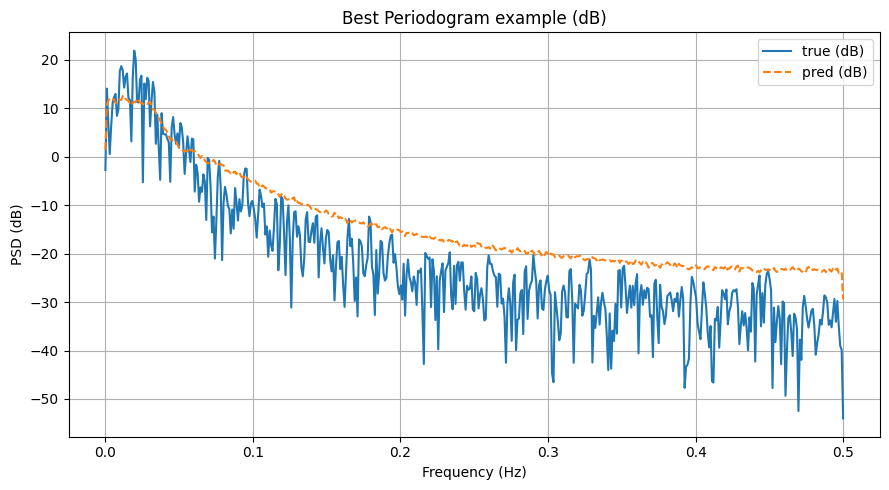

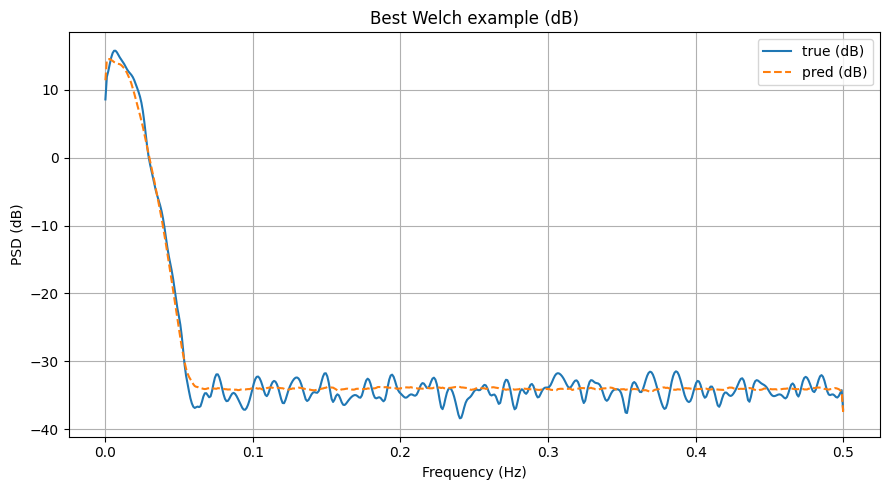

In [ ]:
# Single cell: pick the best-looking sample (max Pearson r) and plot ONE figure for Periodogram
# and ONE figure for Welch, using existing arrays Yt, Yp (both in dB) and frequency axis.
# It does NOT recompute any PSD.

import numpy as np
import matplotlib.pyplot as plt

# --------- Safety: small helpers ----------
def _safe_nan_to_num(a):
    return np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)

def _pearson_r(a, b, eps=1e-12):
    # a,b: 1-D arrays (same length)
    a = _safe_nan_to_num(a.copy())
    b = _safe_nan_to_num(b.copy())
    a = a - a.mean()
    b = b - b.mean()
    num = np.sum(a*b)
    den = np.sqrt(np.sum(a*a)*np.sum(b*b)) + eps
    return float(num/den)

# --------- Preconditions / fallbacks ----------
if 'Yt' not in globals() or 'Yp' not in globals():
    raise RuntimeError("Yt/Yp not found. Run Stage 2 evaluation cells first.")

if 'ONE_SIDED_LEN' not in globals():
    ONE_SIDED_LEN = Yt.shape[1] // 2  # fallback if missing

# Frequency axis fallback
if 'freqs_plot' in globals():
    f = freqs_plot
elif 'freqs' in globals() and isinstance(freqs, np.ndarray) and freqs.size == ONE_SIDED_LEN:
    f = freqs
else:
    f = np.arange(ONE_SIDED_LEN)

# --------- Split heads ----------
yt_per = Yt[:, :ONE_SIDED_LEN]
yp_per = Yp[:, :ONE_SIDED_LEN]
yt_wel = Yt[:, ONE_SIDED_LEN:]
yp_wel = Yp[:, ONE_SIDED_LEN:]

# --------- Pick best sample for each head (max Pearson r) ----------
per_scores = np.array([_pearson_r(yt_per[i], yp_per[i]) for i in range(yt_per.shape[0])])
wel_scores = np.array([_pearson_r(yt_wel[i], yp_wel[i]) for i in range(yt_wel.shape[0])])

best_idx_per = int(np.argmax(per_scores))
best_idx_wel = int(np.argmax(wel_scores))

print(f"[Selection] Best Periodogram idx = {best_idx_per} | r = {per_scores[best_idx_per]:.4f}")
print(f"[Selection] Best Welch        idx = {best_idx_wel} | r = {wel_scores[best_idx_wel]:.4f}")

# --------- Plot Periodogram (one single plot) ----------
plt.figure(figsize=(9, 5))
plt.plot(f, yt_per[best_idx_per], label="true (dB)")
plt.plot(f, yp_per[best_idx_per], linestyle="--", label="pred (dB)")
plt.title("Best Periodogram example (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------- Plot Welch (one single plot) ----------
plt.figure(figsize=(9, 5))
plt.plot(f, yt_wel[best_idx_wel], label="true (dB)")
plt.plot(f, yp_wel[best_idx_wel], linestyle="--", label="pred (dB)")
plt.title("Best Welch example (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Etapa 3

Using device: cuda
Loaded test set: (8000, 1024) (8000, 1026)
[loaded best] epoch=195 val_loss=0.1673
Per-head metrics (dB):
  Periodogram -> MAE=4.8249 RMSE=6.5079 R2=0.7982
  Welch       -> MAE=2.3154 RMSE=3.5190 R2=0.9346


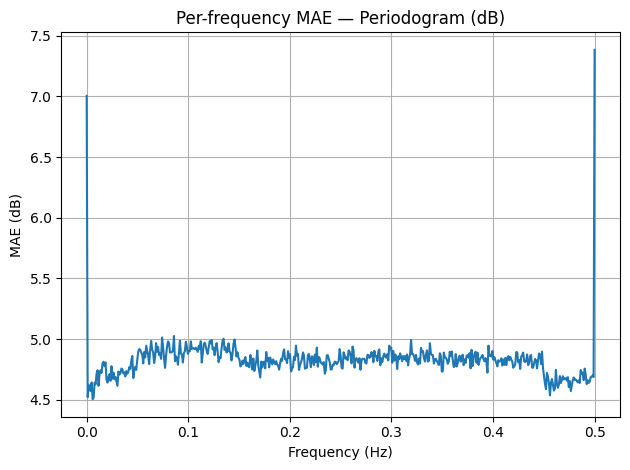

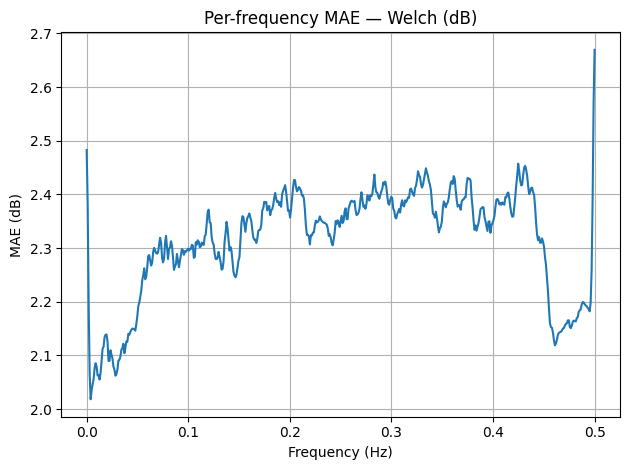

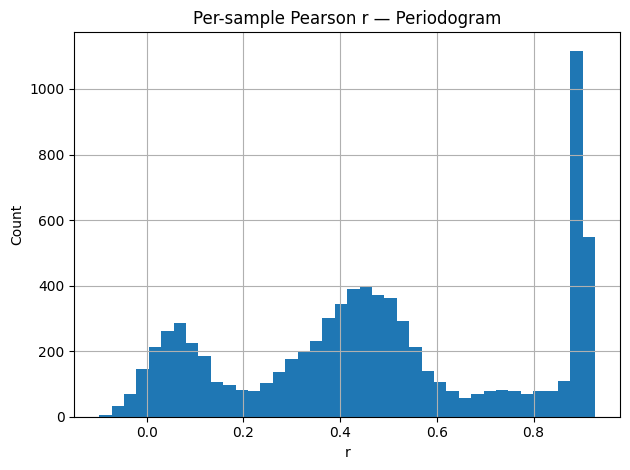

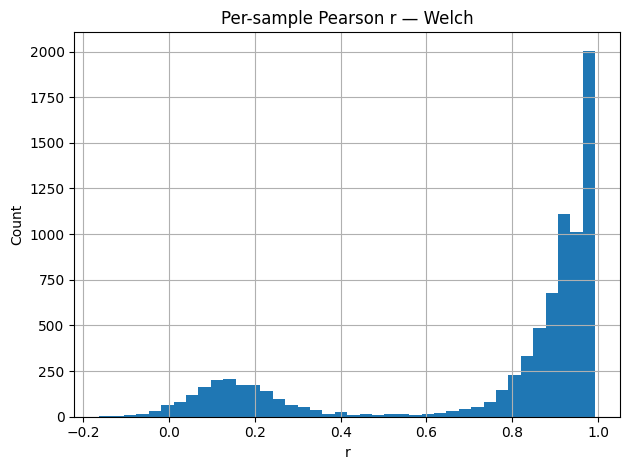

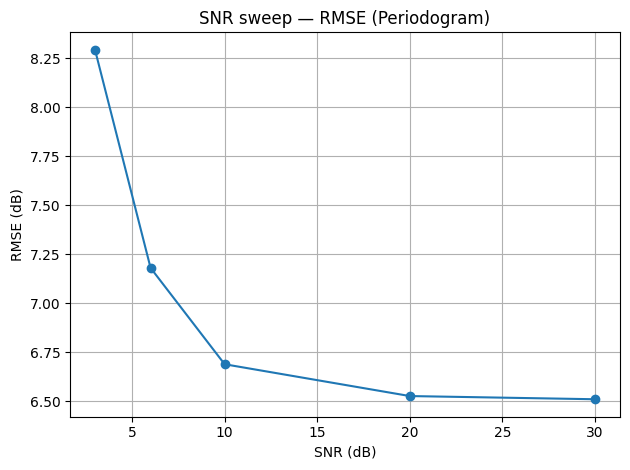

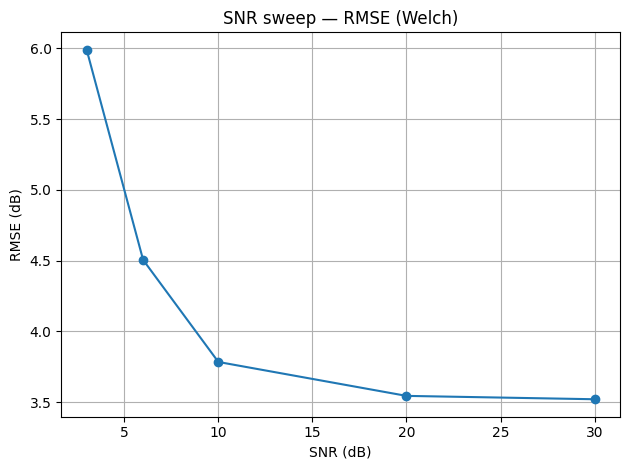

Demo preds shape: (3, 1026)
Saved TorchScript: /content/mlp_psd_stage2_out/mlp_psd_scripted.pt
ONNX already installed.
[warn] First ONNX export attempt failed: ModuleNotFoundError("No module named 'onnxscript'")
Saved ONNX with legacy exporter (fallback): /content/mlp_psd_stage2_out/mlp_psd.onnx
Stage 3 complete. Outputs saved in: /content/mlp_psd_stage2_out


In [ ]:
# =============================================================
# Stage 3 — Evaluation, Robustness, Export & Inference
# Colab-ready • PyTorch • Uses artifacts from Stage 1 & 2
# =============================================================
# What this stage adds:
#  1) Per-head metrics (Periodogram vs Welch) in dB.
#  2) Error analysis: per-frequency error curves; histogram of per-sample Pearson r.
#  3) Robustness sweep: add noise at different SNRs and measure degradation.
#  4) Inference utilities: predict on new raw signals (N=1024), batch & single.
#  5) Export: TorchScript + ONNX (with installer and fallback paths).
# All code is commented in English. One chart per figure. No seaborn.

import os, math, json, time, inspect, warnings
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- Paths (match Stage 2) ----
STAGE1_PATH = "/content/mlp_psd_stage1_out/dataset_stage1.npz"
STAGE2_DIR  = "/content/mlp_psd_stage2_out"
BEST_CKPT   = os.path.join(STAGE2_DIR, "best_mlp_psd.pt")
SCALERS_NPZ = os.path.join(STAGE2_DIR, "scalers_stage2.npz")
OUT_DIR     = STAGE2_DIR

N = 1024
ONE_SIDED_LEN = N // 2 + 1
OUT_DIM = 2 * ONE_SIDED_LEN

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ---------- Cell 1: load artifacts & test set ----------
def load_stage1(path):
    z = np.load(path, allow_pickle=True)
    keys = list(z.keys())
    freqs = z["freqs"] if "freqs" in z else None
    if all(k in keys for k in ["X_train","X_val","X_test",
                               "P_per_train","P_per_val","P_per_test",
                               "P_welch_train","P_welch_val","P_welch_test"]):
        Xte = z["X_test"]
        yte = np.concatenate([z["P_per_test"], z["P_welch_test"]], axis=1)
        return Xte, yte, freqs
    if all(k in keys for k in ["X","y"]):
        from sklearn.model_selection import train_test_split
        X, y = z["X"], z["y"]
        _, Xtmp, _, ytmp = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
        Xva, Xte, yva, yte = train_test_split(Xtmp, ytmp, test_size=0.5, random_state=123, shuffle=True)
        return Xte, yte, freqs
    raise ValueError("Stage1 file does not have expected keys.")

if not os.path.exists(STAGE1_PATH):
    raise FileNotFoundError(f"Stage1 dataset not found at {STAGE1_PATH}. Run Stage 1 first.")

X_test, y_test, freqs = load_stage1(STAGE1_PATH)
print("Loaded test set:", X_test.shape, y_test.shape)

if (freqs is None) or (getattr(freqs, "size", ONE_SIDED_LEN) != ONE_SIDED_LEN):
    freqs_plot = np.arange(ONE_SIDED_LEN)
else:
    freqs_plot = freqs

if not os.path.exists(SCALERS_NPZ):
    raise FileNotFoundError(f"Scalers not found: {SCALERS_NPZ}. Run Stage 2 first.")
scz = np.load(SCALERS_NPZ, allow_pickle=True)
X_mu, X_sd, y_mu, y_sd = scz["X_mu"], scz["X_sd"], scz["y_mu"], scz["y_sd"]

X_test_std = ((X_test - X_mu) / X_sd).astype(np.float32)
y_test_std = ((y_test - y_mu) / y_sd).astype(np.float32)

# ---------- Cell 2: rebuild model & load checkpoint ----------
class MLP_PSD(nn.Module):
    def __init__(self, input_dim, hidden=(1024, 512, 256), out_dim=OUT_DIM, pdrop=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.LayerNorm(h), nn.ReLU(), nn.Dropout(pdrop)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = MLP_PSD(input_dim=X_test_std.shape[1]).to(DEVICE)
if not os.path.exists(BEST_CKPT):
    raise FileNotFoundError(f"Best checkpoint not found at {BEST_CKPT}. Run Stage 2 to train the model.")
ck = torch.load(BEST_CKPT, map_location=DEVICE)
model.load_state_dict(ck["model_state_dict"])
model.eval()
print(f"[loaded best] epoch={ck.get('epoch','?')} val_loss={ck.get('val_loss','?'):.4f}")

# ---------- Cell 3: predictions & metrics (in dB) ----------
@torch.no_grad()
def predict_batch(X_std):
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    yp = model(xb)
    Yp_std = yp.cpu().numpy()
    Yp_db  = Yp_std * y_sd + y_mu
    return Yp_db

Yp_test = predict_batch(X_test_std)
Yt_test = y_test

Yt_per = Yt_test[:, :ONE_SIDED_LEN]
Yp_per = Yp_test[:, :ONE_SIDED_LEN]
Yt_wel = Yt_test[:, ONE_SIDED_LEN:]
Yp_wel = Yp_test[:, ONE_SIDED_LEN:]

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

per_mae  = mean_absolute_error(Yt_per, Yp_per)
per_rmse = rmse(Yt_per, Yp_per)
per_r2   = r2_score(Yt_per, Yp_per)

wel_mae  = mean_absolute_error(Yt_wel, Yp_wel)
wel_rmse = rmse(Yt_wel, Yp_wel)
wel_r2   = r2_score(Yt_wel, Yp_wel)

print("Per-head metrics (dB):")
print(f"  Periodogram -> MAE={per_mae:.4f} RMSE={per_rmse:.4f} R2={per_r2:.4f}")
print(f"  Welch       -> MAE={wel_mae:.4f} RMSE={wel_rmse:.4f} R2={wel_r2:.4f}")

np.savez(os.path.join(OUT_DIR, "stage3_head_metrics.npz"),
         per_mae=per_mae, per_rmse=per_rmse, per_r2=per_r2,
         wel_mae=wel_mae, wel_rmse=wel_rmse, wel_r2=wel_r2)

# ---------- Cell 4: per-frequency MAE plots ----------
per_mae_freq = np.abs(Yt_per - Yp_per).mean(axis=0)
plt.figure()
plt.plot(freqs_plot, per_mae_freq)
plt.title("Per-frequency MAE — Periodogram (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("MAE (dB)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "stage3_per_mae_per_freq.png"), dpi=120)
plt.show()

wel_mae_freq = np.abs(Yt_wel - Yp_wel).mean(axis=0)
plt.figure()
plt.plot(freqs_plot, wel_mae_freq)
plt.title("Per-frequency MAE — Welch (dB)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("MAE (dB)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "stage3_wel_mae_per_freq.png"), dpi=120)
plt.show()

# ---------- Cell 5: Pearson r histograms ----------
def pearsonr_1d(a, b, eps=1e-12):
    a = a - a.mean(); b = b - b.mean()
    num = np.sum(a*b)
    den = np.sqrt(np.sum(a*a)*np.sum(b*b)) + eps
    return float(num/den)

per_r_list = [pearsonr_1d(Yt_per[i], Yp_per[i]) for i in range(Yt_per.shape[0])]
wel_r_list = [pearsonr_1d(Yt_wel[i], Yp_wel[i]) for i in range(Yt_wel.shape[0])]

plt.figure()
plt.hist(per_r_list, bins=40)
plt.title("Per-sample Pearson r — Periodogram")
plt.xlabel("r")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "stage3_hist_pearson_periodogram.png"), dpi=120)
plt.show()

plt.figure()
plt.hist(wel_r_list, bins=40)
plt.title("Per-sample Pearson r — Welch")
plt.xlabel("r")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "stage3_hist_pearson_welch.png"), dpi=120)
plt.show()

# ---------- Cell 6: SNR robustness sweep ----------
SNR_DB_LIST = [3, 6, 10, 20, 30]
snr_results = {"snr_db": [], "per_mae": [], "per_rmse": [], "per_r2": [],
               "wel_mae": [], "wel_rmse": [], "wel_r2": []}

X_test_centered = X_test - X_test.mean(axis=1, keepdims=True)
sig_pow = np.mean(X_test_centered**2, axis=1) + 1e-12

for snr_db in SNR_DB_LIST:
    snr_lin = 10**(snr_db/10.0)
    noise_pow = sig_pow / snr_lin
    noise = np.random.normal(0.0, 1.0, size=X_test.shape).astype(np.float32)
    noise_std = np.sqrt(noise_pow)[:, None]
    noise = noise * noise_std
    X_noisy = X_test + noise
    X_noisy_std = ((X_noisy - X_mu) / X_sd).astype(np.float32)
    Yp_noisy = predict_batch(X_noisy_std)
    Yp_per_n = Yp_noisy[:, :ONE_SIDED_LEN]
    Yp_wel_n = Yp_noisy[:, ONE_SIDED_LEN:]
    per_mae_n  = mean_absolute_error(Yt_per, Yp_per_n)
    per_rmse_n = math.sqrt(mean_squared_error(Yt_per, Yp_per_n))
    per_r2_n   = r2_score(Yt_per, Yp_per_n)
    wel_mae_n  = mean_absolute_error(Yt_wel, Yp_wel_n)
    wel_rmse_n = math.sqrt(mean_squared_error(Yt_wel, Yp_wel_n))
    wel_r2_n   = r2_score(Yt_wel, Yp_wel_n)
    snr_results["snr_db"].append(snr_db)
    snr_results["per_mae"].append(per_mae_n);  snr_results["per_rmse"].append(per_rmse_n);  snr_results["per_r2"].append(per_r2_n)
    snr_results["wel_mae"].append(wel_mae_n);  snr_results["wel_rmse"].append(wel_rmse_n);  snr_results["wel_r2"].append(wel_r2_n)

np.savez(os.path.join(OUT_DIR, "stage3_snr_sweep.npz"), **snr_results)

plt.figure()
plt.plot(snr_results["snr_db"], snr_results["per_rmse"], marker="o")
plt.title("SNR sweep — RMSE (Periodogram)")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (dB)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "stage3_snr_rmse_periodogram.png"), dpi=120)
plt.show()

plt.figure()
plt.plot(snr_results["snr_db"], snr_results["wel_rmse"], marker="o")
plt.title("SNR sweep — RMSE (Welch)")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (dB)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "stage3_snr_rmse_welch.png"), dpi=120)
plt.show()

# ---------- Cell 7: inference utils ----------
@torch.no_grad()
def predict_psd_from_raw(signal_1d):
    assert signal_1d.shape[0] == N, f"Expected signal length {N}"
    x = signal_1d[None, :]
    x_std = ((x - X_mu) / X_sd).astype(np.float32)
    y_pred_db = predict_batch(x_std)[0]
    per_db = y_pred_db[:ONE_SIDED_LEN]
    wel_db = y_pred_db[ONE_SIDED_LEN:]
    return per_db, wel_db

@torch.no_grad()
def predict_psd_from_batch(X_batch):
    assert X_batch.shape[1] == N
    X_std = ((X_batch - X_mu) / X_sd).astype(np.float32)
    return predict_batch(X_std)

demo_preds = predict_psd_from_batch(X_test[:3])
print("Demo preds shape:", demo_preds.shape)

# ---------- Cell 8 (Fixed): export TorchScript & ONNX (robust) ----------
script_path = os.path.join(OUT_DIR, "mlp_psd_scripted.pt")
model.eval()
example_in = torch.randn(1, N, device=DEVICE)
traced = torch.jit.trace(model, example_in)
traced.save(script_path)
print("Saved TorchScript:", script_path)

try:
    import onnx  # type: ignore
    print("ONNX already installed.")
except Exception:
    print("Installing onnx and onnxruntime...")
    os.system("pip install -q onnx onnxruntime")
    import importlib
    onnx = importlib.import_module("onnx")
    print("ONNX installed.")

onnx_path = os.path.join(OUT_DIR, "mlp_psd.onnx")
dummy = torch.randn(1, N, device=DEVICE)
supports_dynamo = False
try:
    sig = inspect.signature(torch.onnx.export)
    supports_dynamo = ("dynamo" in sig.parameters)
except Exception:
    supports_dynamo = False

export_ok = False
try:
    if supports_dynamo:
        torch.onnx.export(
            model, dummy, onnx_path,
            input_names=["input"], output_names=["psd_out"],
            dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
            opset_version=13, dynamo=True,
        )
        export_ok = True
        print("Saved ONNX with torch.onnx.export(dynamo=True):", onnx_path)
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            torch.onnx.export(
                model, dummy, onnx_path,
                input_names=["input"], output_names=["psd_out"],
                dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
                opset_version=13,
            )
        export_ok = True
        print("Saved ONNX with legacy exporter:", onnx_path)
except Exception as e:
    print("[warn] First ONNX export attempt failed:", repr(e))

if not export_ok:
    try:
        if supports_dynamo:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=DeprecationWarning)
                torch.onnx.export(
                    model, dummy, onnx_path,
                    input_names=["input"], output_names=["psd_out"],
                    dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
                    opset_version=13,
                )
            print("Saved ONNX with legacy exporter (fallback):", onnx_path)
        else:
            torch.onnx.export(
                model, dummy, onnx_path,
                input_names=["input"], output_names=["psd_out"],
                dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
                opset_version=13, dynamo=True,
            )
            print("Saved ONNX with dynamo=True (fallback):", onnx_path)
        export_ok = True
    except Exception as e2:
        print("[error] ONNX export failed in all attempts:", repr(e2))

# Optional ONNX check (uncomment if desired)
# try:
#     import onnx
#     m = onnx.load(onnx_path)
#     onnx.checker.check_model(m)
#     print("ONNX model check: OK")
# except Exception as e:
#     print("[warn] Could not validate ONNX model:", e)

print("Stage 3 complete. Outputs saved in:", OUT_DIR)


#Etapa 4

In [ ]:
import os, math, json, time, warnings, inspect, glob, zipfile
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Paths (must match Stage 2 outputs)
STAGE2_DIR  = "/content/mlp_psd_stage2_out"
BEST_CKPT   = os.path.join(STAGE2_DIR, "best_mlp_psd.pt")
SCALERS_NPZ = os.path.join(STAGE2_DIR, "scalers_stage2.npz")

# Stage 4 output dir
STAGE4_DIR  = "/content/mlp_psd_stage4_out"
os.makedirs(STAGE4_DIR, exist_ok=True)

# Put your real signals here (or point to your Drive folder)
DATA_DIR = "/content/real_signals"

# Signal/PSD config
N = 1024
ONE_SIDED_LEN = N // 2 + 1
OUT_DIM = 2 * ONE_SIDED_LEN
FS_DEFAULT = 1.0
WELCH_NPERSEG = 256
WELCH_NOVER   = 128
WINDOW = "hann"
WIN_STRIDE = 512  # window hop in samples

# Figures
PLOT_BEST_PER = os.path.join(STAGE4_DIR, "real_best_periodogram.png")
PLOT_BEST_WEL = os.path.join(STAGE4_DIR, "real_best_welch.png")
PLOT_PER_MAEF = os.path.join(STAGE4_DIR, "real_per_mae_per_freq.png")
PLOT_WEL_MAEF = os.path.join(STAGE4_DIR, "real_wel_mae_per_freq.png")

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Small helpers
def safe_nan_to_num(a):
    return np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)

def pearsonr_1d(a, b, eps=1e-12):
    a = a - a.mean()
    b = b - b.mean()
    num = np.sum(a*b)
    den = np.sqrt(np.sum(a*a)*np.sum(b*b)) + eps
    return float(num/den)

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

print("Stage 4 setup done. If needed, change DATA_DIR and run next cells.")


Using device: cuda
Stage 4 setup done. If needed, change DATA_DIR and run next cells.


In [ ]:
# Load scalers
if not os.path.exists(SCALERS_NPZ):
    raise FileNotFoundError(f"Scalers not found: {SCALERS_NPZ}. Run Stage 2 first.")
scz = np.load(SCALERS_NPZ, allow_pickle=True)
X_mu, X_sd, y_mu, y_sd = scz["X_mu"], scz["X_sd"], scz["y_mu"], scz["y_sd"]
print("Loaded scalers.")

# Rebuild same MLP as Stage 2
class MLP_PSD(nn.Module):
    def __init__(self, input_dim=N, hidden=(1024, 512, 256), out_dim=OUT_DIM, pdrop=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.LayerNorm(h), nn.ReLU(), nn.Dropout(pdrop)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# Load best checkpoint
model = MLP_PSD().to(DEVICE)
if not os.path.exists(BEST_CKPT):
    raise FileNotFoundError(f"Best checkpoint not found: {BEST_CKPT}. Run Stage 2.")
ck = torch.load(BEST_CKPT, map_location=DEVICE)
model.load_state_dict(ck["model_state_dict"])
model.eval()
print(f"[loaded best] epoch={ck.get('epoch','?')} val_loss={ck.get('val_loss','?'):.4f}")


Loaded scalers.
[loaded best] epoch=195 val_loss=0.1673


In [ ]:
# Run this cell ONCE if you have no files in DATA_DIR; it creates 3 sample signals.
import os
os.makedirs(DATA_DIR, exist_ok=True)

rng = np.random.default_rng(42)
N_total = 8192
fs = 1.0
t = np.arange(N_total)/fs

# White noise
sig_white = rng.normal(0.0, 1.0, size=N_total).astype(np.float32)
np.save(os.path.join(DATA_DIR, "white_noise.npy"), sig_white)
np.savetxt(os.path.join(DATA_DIR, "white_noise.csv"), sig_white, delimiter=",")

# Multisine + noise
sig_multi = (1.5*np.sin(2*np.pi*0.07*t + 0.3) +
             0.8*np.sin(2*np.pi*0.15*t - 1.2) +
             0.5*np.sin(2*np.pi*0.32*t + 2.0)).astype(np.float32)
sig_multi += 0.15*rng.normal(0.0, 1.0, size=N_total).astype(np.float32)
np.save(os.path.join(DATA_DIR, "multisine.npy"), sig_multi)
np.savetxt(os.path.join(DATA_DIR, "multisine.csv"), sig_multi, delimiter=",")

# Accel-like
sig_acc = (0.8*np.sin(2*np.pi*0.05*t + 0.1) +
           0.6*np.sin(2*np.pi*0.11*t - 0.6)).astype(np.float32)
idxs = rng.integers(0, N_total, size=15)
sig_acc[idxs] += rng.uniform(2.0, 6.0, size=idxs.shape[0]).astype(np.float32)
sig_acc += 0.2*rng.normal(0.0, 1.0, size=N_total).astype(np.float32)
np.save(os.path.join(DATA_DIR, "accel_like.npy"), sig_acc)
np.savetxt(os.path.join(DATA_DIR, "accel_like.csv"), sig_acc, delimiter=",")

print("Sample signals created in", DATA_DIR)


Sample signals created in /content/real_signals


In [ ]:
# Supported: .npy (1D or 2D first column), .csv (first column), .mat (1D var), .edf (requires mne)
try:
    from scipy.io import loadmat
except Exception:
    loadmat = None
try:
    import mne
except Exception:
    mne = None

def load_one_file(path, fs_default=FS_DEFAULT):
    ext = os.path.splitext(path)[1].lower()
    fs = fs_default
    if ext == ".npy":
        arr = np.load(path, allow_pickle=True)
        if arr.ndim == 1: sig = arr.astype(np.float32)
        elif arr.ndim == 2: sig = arr[:,0].astype(np.float32)
        else: raise ValueError(f"Unsupported npy shape {arr.shape}")
    elif ext == ".csv":
        data = np.loadtxt(path, delimiter=",")
        if data.ndim == 1: sig = data.astype(np.float32)
        else: sig = data[:,0].astype(np.float32)
    elif ext == ".mat":
        if loadmat is None: raise ImportError("scipy.io.loadmat not available")
        md = loadmat(path)
        candidates = [v.squeeze() for v in md.values() if isinstance(v, np.ndarray) and v.ndim==1 and v.size>10]
        if not candidates: raise ValueError("No 1D vector in .mat file")
        sig = max(candidates, key=lambda a:a.size).astype(np.float32)
    elif ext == ".edf":
        if mne is None: raise ImportError("mne not available for EDF")
        raw = mne.io.read_raw_edf(path, preload=True, verbose="ERROR")
        data, edf_fs = raw.get_data(return_times=False), raw.info["sfreq"]
        sig = data[0].astype(np.float32)
        fs = float(edf_fs)
    else:
        raise ValueError(f"Unsupported extension: {ext}")
    sig = safe_nan_to_num(sig)
    sig = sig - np.mean(sig)
    return sig, fs

def make_windows(x, N=1024, stride=512):
    if len(x) < N: return np.zeros((0, N), dtype=np.float32)
    idxs = np.arange(0, len(x)-N+1, stride, dtype=int)
    return np.stack([x[i:i+N] for i in idxs], axis=0).astype(np.float32)

def load_real_dataset(data_dir):
    if not os.path.isdir(data_dir):
        print(f"[warn] DATA_DIR does not exist: {data_dir}")
        return []
    files = []
    for ext in ("*.npy","*.csv","*.mat","*.edf"):
        files.extend(glob.glob(os.path.join(data_dir, ext)))
    files = sorted(files)
    if not files:
        print(f"[warn] No supported files found in {data_dir}")
        return []
    out = []
    for fp in files:
        try:
            sig, fs = load_one_file(fp)
            wins = make_windows(sig, N, WIN_STRIDE)
            if wins.shape[0] == 0:
                print(f"[info] Skipping {fp}: < {N} samples")
                continue
            out.append({"file": fp, "fs": fs, "windows": wins})
            print(f"[ok] {fp} | fs={fs} | windows={wins.shape}")
        except Exception as e:
            print(f"[skip] {fp} -> {e}")
    return out

records = load_real_dataset(DATA_DIR)
print(f"Loaded {len(records)} files from {DATA_DIR}")


[ok] /content/real_signals/accel_like.csv | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/accel_like.npy | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/multisine.csv | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/multisine.npy | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/white_noise.csv | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/white_noise.npy | fs=1.0 | windows=(15, 1024)
Loaded 6 files from /content/real_signals


In [ ]:
from scipy.signal import periodogram, welch

def psd_periodogram_db(x, fs, nfft=N):
    f, Pxx = periodogram(x, fs=fs, window=WINDOW, nfft=nfft, detrend=False,
                         return_onesided=True, scaling="density")
    Pxx_dB = 10.0*np.log10(np.maximum(Pxx, 1e-16)).astype(np.float32)
    return f.astype(np.float32), Pxx_dB

def psd_welch_db(x, fs, nfft=N, nperseg=WELCH_NPERSEG, noverlap=WELCH_NOVER):
    f, Pxx = welch(x, fs=fs, window=WINDOW, nperseg=nperseg, noverlap=noverlap,
                   nfft=nfft, detrend=False, return_onesided=True, scaling="density")
    Pxx_dB = 10.0*np.log10(np.maximum(Pxx, 1e-16)).astype(np.float32)
    return f.astype(np.float32), Pxx_dB

def build_windows_with_gt(records):
    X_all, Y_gt_all, Freqs_all, Index_map = [], [], [], []
    for fi, rec in enumerate(records):
        fs = rec["fs"]
        win = rec["windows"]
        for wi in range(win.shape[0]):
            x = win[wi]
            f1, per_db = psd_periodogram_db(x, fs, N)
            f2, wel_db = psd_welch_db(x, fs, N)
            if per_db.shape[0] != ONE_SIDED_LEN or wel_db.shape[0] != ONE_SIDED_LEN:
                continue
            y = np.concatenate([per_db, wel_db], axis=0)
            X_all.append(x)
            Y_gt_all.append(y)
            Freqs_all.append(f1)    # use periodogram freq axis for plotting
            Index_map.append((fi, wi))
    if not X_all:
        print("[warn] No windows with GT computed.")
        return (np.zeros((0, N), np.float32), np.zeros((0, OUT_DIM), np.float32), [], [])
    return (np.stack(X_all,0).astype(np.float32),
            np.stack(Y_gt_all,0).astype(np.float32),
            Freqs_all, Index_map)

records = load_real_dataset(DATA_DIR)  # re-run in case you just created data
X_real, Y_gt, Freqs_real, Index_map = build_windows_with_gt(records)
print("Windows for eval:", X_real.shape, Y_gt.shape, "Freqs entries:", len(Freqs_real))


[ok] /content/real_signals/accel_like.csv | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/accel_like.npy | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/multisine.csv | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/multisine.npy | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/white_noise.csv | fs=1.0 | windows=(15, 1024)
[ok] /content/real_signals/white_noise.npy | fs=1.0 | windows=(15, 1024)
Windows for eval: (90, 1024) (90, 1026) Freqs entries: 90


In [ ]:
@torch.no_grad()
def infer_batch(X_std):
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    yp = model(xb)
    Yp_std = yp.cpu().numpy()
    Yp_db  = Yp_std * y_sd + y_mu
    return Yp_db

if X_real.shape[0] > 0:
    X_real_std = ((X_real - X_mu) / X_sd).astype(np.float32)
    Y_pred = infer_batch(X_real_std)
else:
    Y_pred = np.zeros_like(Y_gt)

print("Predictions shape:", Y_pred.shape)


Predictions shape: (90, 1026)


Global metrics (concat): {'mae': 4.166516304016113, 'rmse': 5.716122216340259, 'r2': 0.5516385436058044, 'pearson': 0.5408663143714268}
Periodogram metrics: {'mae': 5.172717571258545, 'rmse': 6.9305346464641415, 'r2': 0.4217596650123596, 'pearson': 0.3078797916157378}
Welch metrics: {'mae': 3.1603140830993652, 'rmse': 4.161225517294891, 'r2': 0.681517481803894, 'pearson': 0.639538880243587}
Saved metrics to: /content/mlp_psd_stage4_out


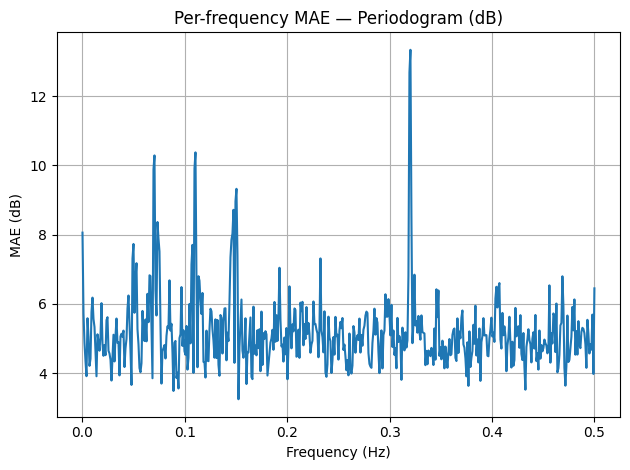

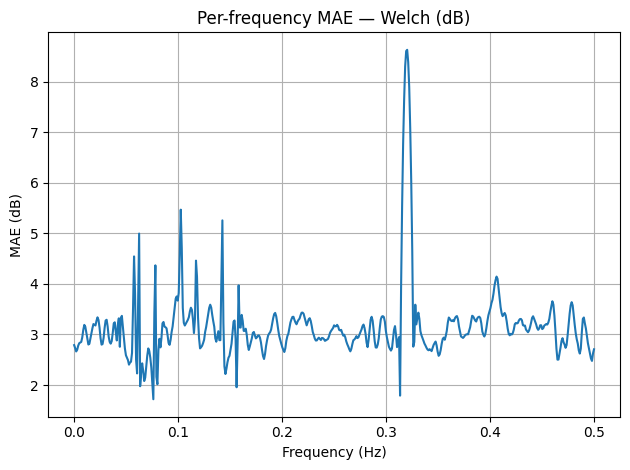

Saved per-frequency plots to: /content/mlp_psd_stage4_out/real_per_mae_per_freq.png and /content/mlp_psd_stage4_out/real_wel_mae_per_freq.png


In [ ]:
def per_head_split(Y):
    return Y[:, :ONE_SIDED_LEN], Y[:, ONE_SIDED_LEN:]

def aggregate_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse_ = math.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    r_list = [pearsonr_1d(y_true[i], y_pred[i]) for i in range(y_true.shape[0])]
    r = float(np.nanmean(r_list)) if len(r_list) else float("nan")
    return dict(mae=mae, rmse=rmse_, r2=r2, pearson=r)

if Y_gt.shape[0] == 0 or Y_pred.shape[0] == 0:
    print("[warn] No windows available for metrics. Create or upload data to DATA_DIR and rerun.")
    empty = {"mae": float("nan"), "rmse": float("nan"), "r2": float("nan"), "pearson": float("nan")}
    with open(os.path.join(STAGE4_DIR, "metrics_global.json"), "w") as f:
        json.dump({"global_concat": empty, "periodogram": empty, "welch": empty}, f, indent=2)
    with open(os.path.join(STAGE4_DIR, "metrics_per_file.json"), "w") as f:
        json.dump({}, f, indent=2)

    f_plot = np.arange(ONE_SIDED_LEN)
    plt.figure(); plt.plot(f_plot, np.zeros_like(f_plot))
    plt.title("Per-frequency MAE — Periodogram (dB) [EMPTY]")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("MAE (dB)"); plt.grid(True); plt.tight_layout()
    plt.savefig(PLOT_PER_MAEF, dpi=120); plt.show()

    plt.figure(); plt.plot(f_plot, np.zeros_like(f_plot))
    plt.title("Per-frequency MAE — Welch (dB) [EMPTY]")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("MAE (dB)"); plt.grid(True); plt.tight_layout()
    plt.savefig(PLOT_WEL_MAEF, dpi=120); plt.show()
else:
    # Global concatenated metrics
    global_metrics = aggregate_metrics(Y_gt, Y_pred)
    print("Global metrics (concat):", global_metrics)

    gt_per, gt_wel = per_head_split(Y_gt)
    pr_per, pr_wel = per_head_split(Y_pred)
    m_per = aggregate_metrics(gt_per, pr_per)
    m_wel = aggregate_metrics(gt_wel, pr_wel)
    print("Periodogram metrics:", m_per)
    print("Welch metrics:", m_wel)

    # Per-file aggregation
    from collections import defaultdict
    file_metrics = {}
    idx_by_file = defaultdict(list)
    for row_idx, (fi, wi) in enumerate(Index_map):
        idx_by_file[fi].append(row_idx)
    for fi, rows in idx_by_file.items():
        yt_f = Y_gt[rows]; yp_f = Y_pred[rows]
        file_metrics[records[fi]["file"]] = {
            "concat":      aggregate_metrics(yt_f, yp_f),
            "periodogram": aggregate_metrics(yt_f[:, :ONE_SIDED_LEN], yp_f[:, :ONE_SIDED_LEN]),
            "welch":       aggregate_metrics(yt_f[:, ONE_SIDED_LEN:], yp_f[:, ONE_SIDED_LEN:])
        }

    with open(os.path.join(STAGE4_DIR, "metrics_global.json"), "w") as f:
        json.dump({"global_concat": global_metrics, "periodogram": m_per, "welch": m_wel}, f, indent=2)
    with open(os.path.join(STAGE4_DIR, "metrics_per_file.json"), "w") as f:
        json.dump(file_metrics, f, indent=2)
    print("Saved metrics to:", STAGE4_DIR)

    # Per-frequency MAE plots
    per_mae_freq = np.abs(gt_per - pr_per).mean(axis=0)
    wel_mae_freq = np.abs(gt_wel - pr_wel).mean(axis=0)
    f_plot = Freqs_real[0] if (len(Freqs_real)>0 and Freqs_real[0].shape[0]==ONE_SIDED_LEN) else np.arange(ONE_SIDED_LEN)

    plt.figure(); plt.plot(f_plot, per_mae_freq)
    plt.title("Per-frequency MAE — Periodogram (dB)")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("MAE (dB)")
    plt.grid(True); plt.tight_layout(); plt.savefig(PLOT_PER_MAEF, dpi=120); plt.show()

    plt.figure(); plt.plot(f_plot, wel_mae_freq)
    plt.title("Per-frequency MAE — Welch (dB)")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("MAE (dB)")
    plt.grid(True); plt.tight_layout(); plt.savefig(PLOT_WEL_MAEF, dpi=120); plt.show()

    print("Saved per-frequency plots to:", PLOT_PER_MAEF, "and", PLOT_WEL_MAEF)


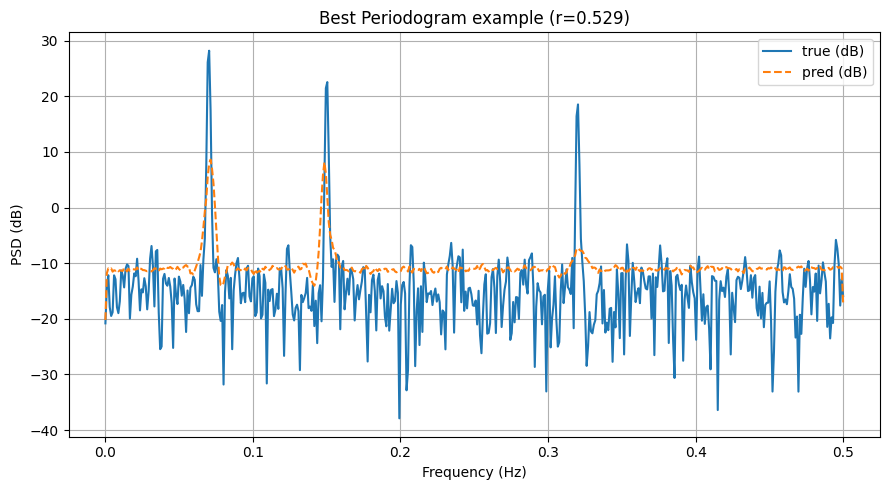

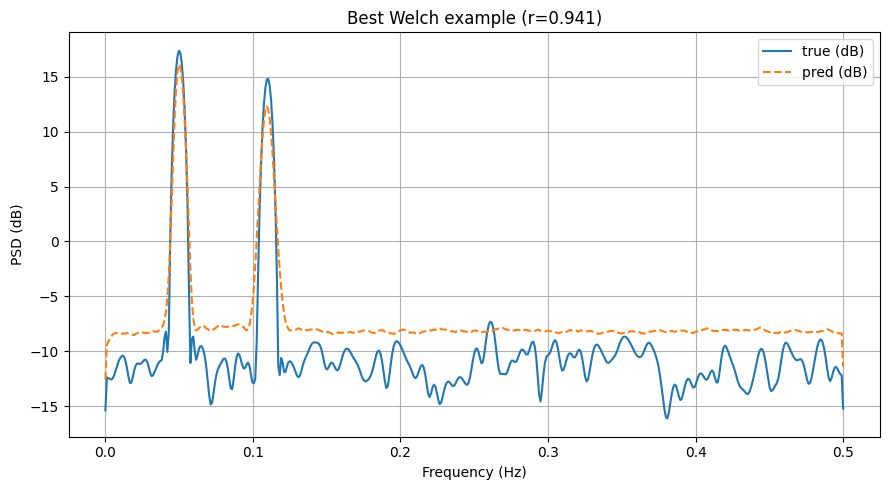

Saved best-example plots to: /content/mlp_psd_stage4_out/real_best_periodogram.png and /content/mlp_psd_stage4_out/real_best_welch.png


In [ ]:
if Y_gt.shape[0] == 0:
    print("[info] No windows to plot best examples. Skipping.")
else:
    gt_per, gt_wel = Y_gt[:, :ONE_SIDED_LEN], Y_gt[:, ONE_SIDED_LEN:]
    pr_per, pr_wel = Y_pred[:, :ONE_SIDED_LEN], Y_pred[:, ONE_SIDED_LEN:]

    per_scores = np.array([pearsonr_1d(gt_per[i], pr_per[i]) for i in range(gt_per.shape[0])])
    wel_scores = np.array([pearsonr_1d(gt_wel[i], pr_wel[i]) for i in range(gt_wel.shape[0])])
    best_idx_per = int(np.nanargmax(per_scores))
    best_idx_wel = int(np.nanargmax(wel_scores))

    f_per = Freqs_real[best_idx_per] if len(Freqs_real)>best_idx_per else np.arange(ONE_SIDED_LEN)
    plt.figure(figsize=(9,5))
    plt.plot(f_per, gt_per[best_idx_per], label="true (dB)")
    plt.plot(f_per, pr_per[best_idx_per], linestyle="--", label="pred (dB)")
    plt.title(f"Best Periodogram example (r={per_scores[best_idx_per]:.3f})")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD (dB)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.savefig(PLOT_BEST_PER, dpi=120); plt.show()

    f_wel = Freqs_real[best_idx_wel] if len(Freqs_real)>best_idx_wel else np.arange(ONE_SIDED_LEN)
    plt.figure(figsize=(9,5))
    plt.plot(f_wel, gt_wel[best_idx_wel], label="true (dB)")
    plt.plot(f_wel, pr_wel[best_idx_wel], linestyle="--", label="pred (dB)")
    plt.title(f"Best Welch example (r={wel_scores[best_idx_wel]:.3f})")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD (dB)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.savefig(PLOT_BEST_WEL, dpi=120); plt.show()

    print("Saved best-example plots to:", PLOT_BEST_PER, "and", PLOT_BEST_WEL)


In [ ]:
# Uses TorchScript and (if available) ONNX, plus scalers and a CLI script.
TS_PATH   = os.path.join(STAGE2_DIR, "mlp_psd_scripted.pt")
ONNX_PATH = os.path.join(STAGE2_DIR, "mlp_psd.onnx")

# TorchScript (create if missing)
if not os.path.exists(TS_PATH):
    example_in = torch.randn(1, N, device=DEVICE)
    traced = torch.jit.trace(model, example_in)
    traced.save(TS_PATH)
    print("Saved TorchScript:", TS_PATH)
else:
    print("Found TorchScript:", TS_PATH)

# Best-effort ONNX (optional)
if not os.path.exists(ONNX_PATH):
    print("[info] Attempting to export ONNX...")
    try:
        try:
            import onnx  # type: ignore
            print("ONNX available.")
        except Exception:
            print("Installing onnx and onnxruntime (Colab)...")
            os.system("pip install -q onnx onnxruntime")
            import importlib
            onnx = importlib.import_module("onnx")
            print("ONNX installed.")
        dummy = torch.randn(1, N, device=DEVICE)
        supports_dynamo = False
        try:
            sig = inspect.signature(torch.onnx.export)
            supports_dynamo = ("dynamo" in sig.parameters)
        except Exception:
            supports_dynamo = False
        if supports_dynamo:
            torch.onnx.export(
                model, dummy, ONNX_PATH,
                input_names=["input"], output_names=["psd_out"],
                dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
                opset_version=13, dynamo=True,
            )
            print("Saved ONNX (dynamo):", ONNX_PATH)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=DeprecationWarning)
                torch.onnx.export(
                    model, dummy, ONNX_PATH,
                    input_names=["input"], output_names=["psd_out"],
                    dynamic_axes={"input": {0: "batch"}, "psd_out": {0: "batch"}},
                    opset_version=13,
                )
            print("Saved ONNX (legacy):", ONNX_PATH)
    except Exception as e:
        print("[warn] Could not create ONNX:", e)
else:
    print("Found ONNX:", ONNX_PATH)

# Write CLI inference script + README, copy scalers & models, zip
infer_py = f"""#!/usr/bin/env python3
import os, argparse, numpy as np, torch
N = {N}
ONE_SIDED_LEN = N//2 + 1
def load_input(path, use_csv=False):
    if use_csv: data = np.loadtxt(path, delimiter=",")
    else: data = np.load(path, allow_pickle=True)
    if data.ndim == 1 and data.shape[0] == N: X = data[None,:].astype(np.float32)
    elif data.ndim == 2 and data.shape[1] == N: X = data.astype(np.float32)
    else: raise ValueError("Expected 1D length N or 2D [B,N]")
    return X
def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--model", default="mlp_psd_scripted.pt")
    ap.add_argument("--mean_std", default="scalers_stage2.npz")
    ap.add_argument("--input", required=True)
    ap.add_argument("--out", required=True)
    ap.add_argument("--csv", action="store_true")
    args = ap.parse_args()
    scz = np.load(args.mean_std, allow_pickle=True)
    X_mu, X_sd, y_mu, y_sd = scz["X_mu"], scz["X_sd"], scz["y_mu"], scz["y_sd"]
    X = load_input(args.input, use_csv=args.csv)
    X_std = ((X - X_mu) / X_sd).astype(np.float32)
    model = torch.jit.load(args.model, map_location=torch.device("cpu"))
    model.eval()
    with torch.no_grad():
        xb = torch.from_numpy(X_std)
        y_std = model(xb).cpu().numpy()
        y_db  = y_std*y_sd + y_mu
    per = y_db[:, :ONE_SIDED_LEN]
    wel = y_db[:, ONE_SIDED_LEN:]
    np.savez(args.out, y_concat=y_db, y_per=per, y_wel=wel)
    print("Saved:", args.out)
if __name__ == "__main__":
    main()
"""

readme_txt = f"""MLP PSD Inference Package

Contents:
- mlp_psd_scripted.pt (TorchScript)
- mlp_psd.onnx (optional)
- scalers_stage2.npz (normalization)
- infer_mlp_psd.py (CLI)

Usage:
  python infer_mlp_psd.py --input input.npy --out out.npz
  (for CSV)
  python infer_mlp_psd.py --csv --input input.csv --out out.npz

Outputs:
- y_concat: shape [B, {2*ONE_SIDED_LEN}] in dB
- y_per:    shape [B, {ONE_SIDED_LEN}] in dB (Periodogram)
- y_wel:    shape [B, {ONE_SIDED_LEN}] in dB (Welch)
"""

INF_PY = os.path.join(STAGE4_DIR, "infer_mlp_psd.py")
with open(INF_PY, "w") as f: f.write(infer_py)
README = os.path.join(STAGE4_DIR, "README_inference.txt")
with open(README, "w") as f: f.write(readme_txt)

# Copy scalers
SCALERS_COPY = os.path.join(STAGE4_DIR, "scalers_stage2.npz")
if not os.path.exists(SCALERS_COPY):
    import shutil
    shutil.copy(SCALERS_NPZ, SCALERS_COPY)

# Copy TorchScript and maybe ONNX
TS_PATH = os.path.join(STAGE2_DIR, "mlp_psd_scripted.pt")
if os.path.exists(TS_PATH):
    TS_COPY = os.path.join(STAGE4_DIR, "mlp_psd_scripted.pt")
    if not os.path.exists(TS_COPY):
        import shutil; shutil.copy(TS_PATH, TS_COPY)
ONNX_PATH = os.path.join(STAGE2_DIR, "mlp_psd.onnx")
if os.path.exists(ONNX_PATH):
    ONNX_COPY = os.path.join(STAGE4_DIR, "mlp_psd.onnx")
    if not os.path.exists(ONNX_COPY):
        import shutil; shutil.copy(ONNX_PATH, ONNX_COPY)

# Create zip
ZIP_PATH = os.path.join(STAGE2_DIR, "inference_package.zip")
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zf:
    for name in ("infer_mlp_psd.py","README_inference.txt","scalers_stage2.npz","mlp_psd_scripted.pt","mlp_psd.onnx"):
        p = os.path.join(STAGE4_DIR, name)
        if os.path.exists(p): zf.write(p, arcname=name)
print("Inference package created at:", ZIP_PATH)


Found TorchScript: /content/mlp_psd_stage2_out/mlp_psd_scripted.pt
Found ONNX: /content/mlp_psd_stage2_out/mlp_psd.onnx
Inference package created at: /content/mlp_psd_stage2_out/inference_package.zip


#Etapa 5

[info] Input had 84 samples; zero-padded to 1024.
[debug] per_true len=513 | wel_true len=513
[debug] y_pred total len=1026
[debug] per_pred len=513 | wel_pred len=513
Periodogram metrics (dB): {'MAE': 11.61938762664795, 'RMSE': 13.250250472094564, 'R2': -1.9439382553100586, 'Pearson_r': 0.5901419520378113}
Welch metrics (dB): {'MAE': 26.43349838256836, 'RMSE': 28.238489557348295, 'R2': -13.086954116821289, 'Pearson_r': 0.5805471539497375}


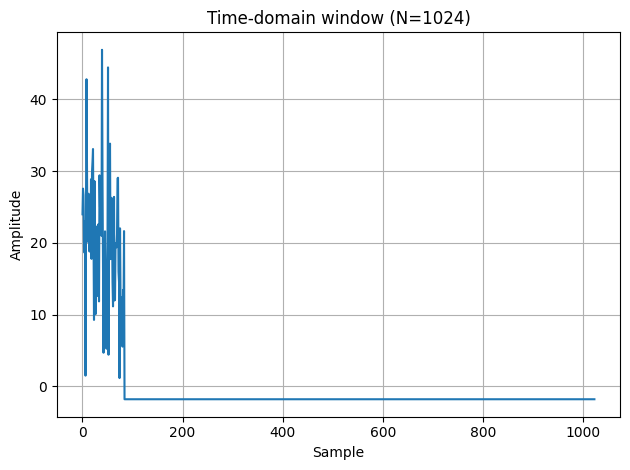

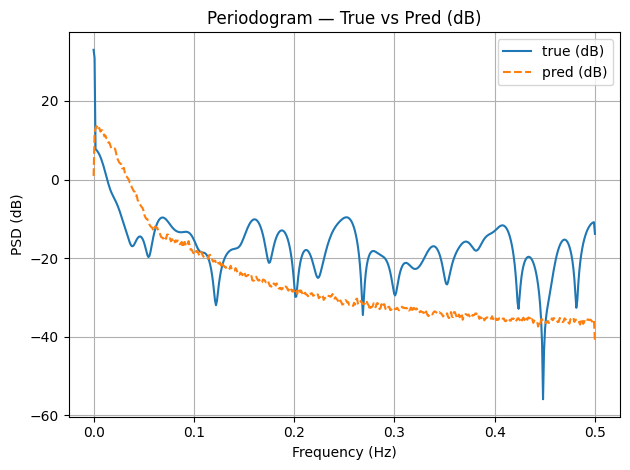

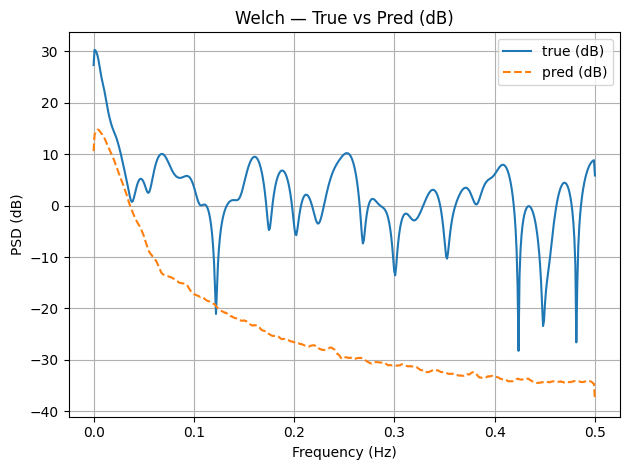

Saved outputs in: /content/mlp_psd_stage5_out


In [ ]:
# One cell — CSV column → analytical PSD vs MLP prediction (robust, with shape checks)
# English comments • Single-plot figures • No seaborn

import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.signal import periodogram, welch

# ==== USER CONFIG ====
file = "/content/mental-state.csv"   # CSV file path
columna = "lag1_mean_0"                 # column in the CSV to analyze
FS_DEFAULT = 1                      # Hz (edit if you know your real fs)

# ==== Stage-2 artifacts ====
STAGE2_DIR  = "/content/mlp_psd_stage2_out"
BEST_CKPT   = os.path.join(STAGE2_DIR, "best_mlp_psd.pt")
SCALERS_NPZ = os.path.join(STAGE2_DIR, "scalers_stage2.npz")

# ==== Output ====
OUT_DIR = "/content/mlp_psd_stage5_out"
os.makedirs(OUT_DIR, exist_ok=True)

# ==== Constants ====
N = 1024
ONE_SIDED_LEN = N//2 + 1     # 513
OUT_DIM = 2*ONE_SIDED_LEN    # 1026
WINDOW = "hann"
WELCH_NPERSEG = 256
WELCH_NOVER   = 128

# ==== 1) Load CSV column ====
if not os.path.exists(file):
    raise FileNotFoundError(f"CSV not found: {file}")
df = pd.read_csv(file)
if columna not in df.columns:
    raise ValueError(f"Column '{columna}' not in CSV. Available: {list(df.columns)}")

x_full = df[columna].dropna().astype(np.float32).values
Nsig = len(x_full)

# window (zero-pad if short)
if Nsig < N:
    pad = N - Nsig
    x_win = np.pad(x_full, (0, pad), mode="constant").astype(np.float32)
    start = 0
    print(f"[info] Input had {Nsig} samples; zero-padded to {N}.")
else:
    start = max(0, (Nsig - N)//2)
    x_win = x_full[start:start+N].astype(np.float32)
    print(f"[info] Using centered window: start={start}, length={len(x_win)}")

# remove DC
x_win -= float(np.mean(x_win))

# ==== 2) Analytical PSDs (dB) ====
def psd_periodogram_db(x, fs, nfft=N):
    f, Pxx = periodogram(x, fs=fs, window=WINDOW, nfft=nfft, detrend=False,
                         return_onesided=True, scaling="density")
    Pxx_dB = 10.0*np.log10(np.maximum(Pxx, 1e-16))
    return f.astype(np.float32), Pxx_dB.astype(np.float32)

def psd_welch_db(x, fs, nfft=N, nperseg=WELCH_NPERSEG, noverlap=WELCH_NOVER):
    f, Pxx = welch(x, fs=fs, window=WINDOW, nperseg=nperseg, noverlap=noverlap,
                   nfft=nfft, detrend=False, return_onesided=True, scaling="density")
    Pxx_dB = 10.0*np.log10(np.maximum(Pxx, 1e-16))
    return f.astype(np.float32), Pxx_dB.astype(np.float32)

fs = FS_DEFAULT
f_per, per_true = psd_periodogram_db(x_win, fs, N)
f_wel, wel_true = psd_welch_db(x_win, fs, N, WELCH_NPERSEG, WELCH_NOVER)

per_true = np.asarray(per_true).ravel()
wel_true = np.asarray(wel_true).ravel()

print(f"[debug] per_true len={per_true.shape[0]} | wel_true len={wel_true.shape[0]}")
if per_true.shape[0] != ONE_SIDED_LEN or wel_true.shape[0] != ONE_SIDED_LEN:
    raise RuntimeError(f"Analytical PSD length mismatch. Got per={per_true.shape[0]}, wel={wel_true.shape[0]}, expected {ONE_SIDED_LEN}.")

# ==== 3) Load MLP & scalers ====
if not os.path.exists(SCALERS_NPZ):
    raise FileNotFoundError(f"Scalers not found: {SCALERS_NPZ}")
scz = np.load(SCALERS_NPZ, allow_pickle=True)
X_mu, X_sd, y_mu, y_sd = scz["X_mu"], scz["X_sd"], scz["y_mu"], scz["y_sd"]

class MLP_PSD(nn.Module):
    def __init__(self, input_dim=N, hidden=(1024,512,256), out_dim=OUT_DIM, pdrop=0.2):
        super().__init__()
        L, prev = [], input_dim
        for h in hidden:
            L += [nn.Linear(prev,h), nn.LayerNorm(h), nn.ReLU(), nn.Dropout(pdrop)]
            prev = h
        L += [nn.Linear(prev,out_dim)]
        self.net = nn.Sequential(*L)
    def forward(self,x): return self.net(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_PSD().to(DEVICE)
if not os.path.exists(BEST_CKPT):
    raise FileNotFoundError(f"Best checkpoint not found: {BEST_CKPT}")
ck = torch.load(BEST_CKPT, map_location=DEVICE)
model.load_state_dict(ck["model_state_dict"])
model.eval()

# ==== 4) Predict (dB) ====
@torch.no_grad()
def predict_one_win(x_1d):
    x_std = ((x_1d[None,:] - X_mu) / X_sd).astype(np.float32)  # [1,N]
    xb = torch.from_numpy(x_std).to(DEVICE)
    y_std = model(xb).cpu().numpy()[0]
    y_db  = y_std * y_sd + y_mu
    return np.asarray(y_db).ravel()

y_pred = predict_one_win(x_win)
print(f"[debug] y_pred total len={y_pred.shape[0]}")
if y_pred.shape[0] != OUT_DIM:
    raise RuntimeError(f"Model output length mismatch. Got {y_pred.shape[0]}, expected {OUT_DIM}.")

per_pred = y_pred[:ONE_SIDED_LEN].ravel()
wel_pred = y_pred[ONE_SIDED_LEN:ONE_SIDED_LEN*2].ravel()
print(f"[debug] per_pred len={per_pred.shape[0]} | wel_pred len={wel_pred.shape[0]}")

# Final guards (no empty arrays allowed)
if per_pred.shape[0] == 0 or wel_pred.shape[0] == 0:
    raise RuntimeError("Prediction arrays are empty after slicing. Aborting to avoid zero-length metrics.")

# ==== 5) Metrics ====
def pearsonr_1d(a,b,eps=1e-12):
    a = a - a.mean(); b = b - b.mean()
    num = np.sum(a*b); den = np.sqrt(np.sum(a*a)*np.sum(b*b)) + eps
    return float(num/den)
def rmse(a,b): return math.sqrt(mean_squared_error(a,b))
from sklearn.metrics import mean_squared_error

m_per = {
    "MAE": float(mean_absolute_error(per_true, per_pred)),
    "RMSE": float(rmse(per_true, per_pred)),
    "R2": float(r2_score(per_true, per_pred)),
    "Pearson_r": float(pearsonr_1d(per_true, per_pred))
}
m_wel = {
    "MAE": float(mean_absolute_error(wel_true, wel_pred)),
    "RMSE": float(rmse(wel_true, wel_pred)),
    "R2": float(r2_score(wel_true, wel_pred)),
    "Pearson_r": float(pearsonr_1d(wel_true, wel_pred))
}
print("Periodogram metrics (dB):", m_per)
print("Welch metrics (dB):", m_wel)

with open(os.path.join(OUT_DIR, "metrics_stage5.json"), "w") as f:
    json.dump({
        "file": file, "column": columna, "fs": float(FS_DEFAULT), "start": int(start),
        "periodogram": m_per, "welch": m_wel,
        "note": "If input had <1024 samples, zero-padding to 1024 was applied."
    }, f, indent=2)

# ==== 6) Plots ====
plt.figure()
plt.plot(np.arange(N), x_win)
plt.title("Time-domain window (N=1024)")
plt.xlabel("Sample"); plt.ylabel("Amplitude")
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"time_window.png"), dpi=120); plt.show()

plt.figure()
plt.plot(f_per, per_true, label="true (dB)")
plt.plot(f_per, per_pred, linestyle="--", label="pred (dB)")
plt.title("Periodogram — True vs Pred (dB)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD (dB)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"periodogram_true_vs_pred.png"), dpi=120); plt.show()

plt.figure()
plt.plot(f_wel, wel_true, label="true (dB)")
plt.plot(f_wel, wel_pred, linestyle="--", label="pred (dB)")
plt.title("Welch — True vs Pred (dB)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD (dB)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"welch_true_vs_pred.png"), dpi=120); plt.show()

print("Saved outputs in:", OUT_DIR)
